# Part 1: What is Neural Memory?

https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

If you wanted to train a neural network to predict where the ball would be in the next frame, it would be really helpful to know where the ball was in the last frame! Sequential data like this is why we build recurrent neural networks. So, how does a neural network remember what it saw in previous time steps?


Neural networks have hidden layers. Normally, the state of your hidden layer is based ONLY on your input data. So, normally a neural network's information flow would look like this:

input -> hidden -> output

This is straightforward

Certain types of input create certain types of hidden layers. Certain types of hidden layers create certain types of output layers. It's kindof a closed system. Memory changes this. Memory means that the hidden layer is a combination of your input data at the current timestep and the hidden layer of the previous timestep.


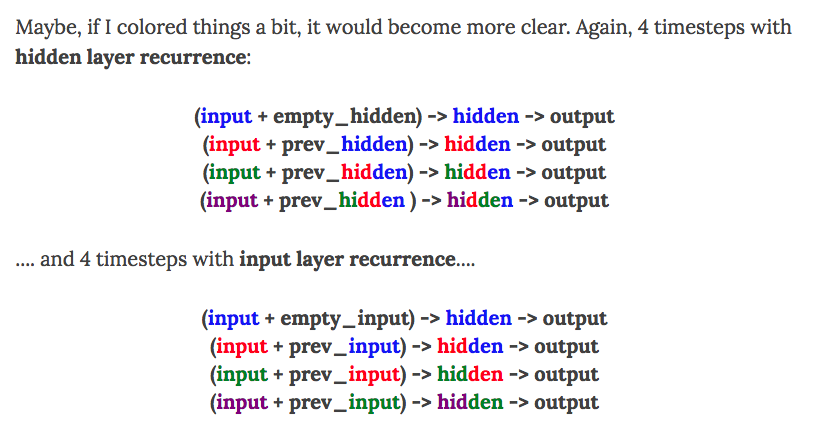

Now that we have the intuition, let's dive down a layer (ba dum bump...). As described in the backpropagation post, our input layer to the neural network is determined by our input dataset. Each row of input data is used to generate the hidden layer (via forward propagation). Each hidden layer is then used to populate the output layer (assuming only 1 hidden layer). As we just saw, memory means that the hidden layer is a combination of the input data and the previous hidden layer. How is this done? Well, much like every other propagation in neural networks, it's done with a matrix. This matrix defines the relationship between the previous hidden layer and the current one.

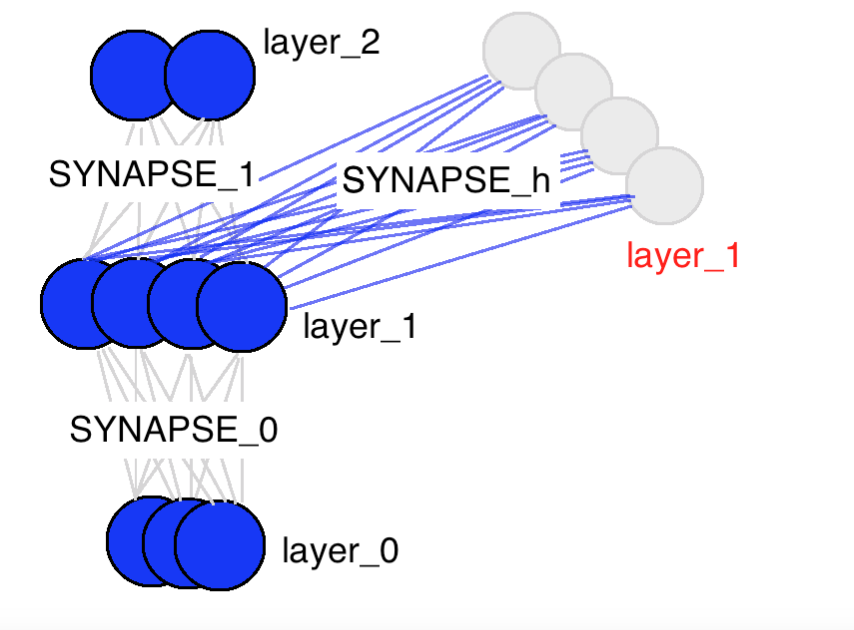

Big thing to take from this picture, there are only three weight matrices. Two of them should be very familiar (same names too). SYNAPSE_0 propagates the input data to the hidden layer. SYNAPSE_1 propagates the hidden layer to the output data. The new matrix (SYNAPSE_h....the recurrent one), propagates from the hidden layer (layer_1) to the hidden layer at the next timestep (still layer_1).



#  binary addition

We're going to be using a recurrent neural network to model binary addition

Don't get too caught up in the problem. The network actually doesn't care too much. Just recognize that we're going to have two inputs at each time step, (either a one or a zero from each number begin added). These two inputs will be propagated to the hidden layer, which will have to remember whether or not we carry. The prediction will take all of this information into account to predict the correct bit at the given position (time step).

In [44]:
import copy, numpy as np
np.random.seed(0)

# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)

# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(
    np.array([list(range(largest_number))],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]

# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1


# initialize neural network weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1

synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

In [45]:
# generate a simple addition problem (a + b = c)
a_int = np.random.randint(largest_number/2) # int version
a = int2binary[a_int] # binary encoding

b_int = np.random.randint(largest_number/2) # int version
b = int2binary[b_int] # binary encoding

# true answer
c_int = a_int + b_int
c = int2binary[c_int]

In [ ]:
# training logic
for j in range(10000):
    
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary encoding

    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary encoding

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # where we'll store our best guess (binary encoded)
    d = np.zeros_like(c)

    overallError = 0
    
    layer_2_deltas = list()
    layer_1_values = list()
    layer_1_values.append(np.zeros(hidden_dim))
    
    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))

        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))

        # did we miss?... if so, by how much?
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
        overallError += np.abs(layer_2_error[0])
    
        # decode estimate so we can print it out
        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        
        # store hidden layer so we can use it in the next timestep
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
    for position in range(binary_dim):
        
        X = np.array([[a[position],b[position]]])
        layer_1 = layer_1_values[-position-1]
        prev_layer_1 = layer_1_values[-position-2]
        
        # error at output layer
        layer_2_delta = layer_2_deltas[-position-1]
        # error at hidden layer
        layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)

        # let's update all our weights so we can try again
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        synapse_0_update += X.T.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    

    synapse_0 += synapse_0_update * alpha
    synapse_1 += synapse_1_update * alpha
    synapse_h += synapse_h_update * alpha    

    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0
    
    # print out progress
    if(j % 1000 == 0):
        print("Error:" + str(overallError))
        print("Pred:" + str(d))
        print("True:" + str(c))
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out))
        print("------------")

In [ ]:
import copy, numpy as np
np.random.seed(0)

# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)

# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(
    np.array([list(range(largest_number))],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]

# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1


# initialize neural network weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1

synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

# training logic
for j in range(10000):
    
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary encoding

    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary encoding

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # where we'll store our best guess (binary encoded)
    d = np.zeros_like(c)

    overallError = 0
    
    layer_2_deltas = list()
    layer_1_values = list()
    layer_1_values.append(np.zeros(hidden_dim))
    
    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))

        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))

        # did we miss?... if so, by how much?
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
        overallError += np.abs(layer_2_error[0])
    
        # decode estimate so we can print it out
        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        
        # store hidden layer so we can use it in the next timestep
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
    for position in range(binary_dim):
        
        X = np.array([[a[position],b[position]]])
        layer_1 = layer_1_values[-position-1]
        prev_layer_1 = layer_1_values[-position-2]
        
        # error at output layer
        layer_2_delta = layer_2_deltas[-position-1]
        # error at hidden layer
        layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)

        # let's update all our weights so we can try again
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        synapse_0_update += X.T.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    

    synapse_0 += synapse_0_update * alpha
    synapse_1 += synapse_1_update * alpha
    synapse_h += synapse_h_update * alpha    

    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0
    
    # print out progress
    if(j % 1000 == 0):
        print("Error:" + str(overallError))
        print("Pred:" + str(d))
        print("True:" + str(c))
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out))
        print("------------")